<a href="https://colab.research.google.com/github/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/blob/main/PIU_Model_Fitting_With_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MMAI 869, Smith School of Business at Queens University
###Team Broadview Project, Pump it Up: Data Mining the Water Table

#Install and ImportRequired Libraries

In [289]:
# pip install feature_engine

In [290]:
# pip install category_encoders

###Import Libraries

In [291]:
import sys
import numpy as np  
import pandas as pd  
import datetime as dt

# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import plot_roc_curve
from sklearn import metrics

from feature_engine.encoding import RareLabelEncoder

from category_encoders import OneHotEncoder, TargetEncoder, JamesSteinEncoder, CatBoostEncoder, MEstimateEncoder, WOEEncoder, LeaveOneOutEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


### Check Allocated System Specs by Google Colab

In [292]:
from psutil import *

cpu_count()

2

In [293]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [294]:
!df -h / |awk '{print $4}'

Avail
85G


In [295]:
!free -h  --si | awk '/Mem:/{print $2}'

13G


In [296]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [297]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#1. Loading the dataset from GitHub: [MMAI869-Pump-it-Up-Competition]

  Data is accessed from github: (https://github.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition)



In [298]:
train_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/preprocessed_data.csv'
test_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/preprocessed_test.csv'
tt_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/clean.csv'
# ulr_Test_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Test_Set_Values.csv'
data = pd.read_csv(train_ulr)
test = pd.read_csv(test_ulr)
train2 = pd.read_csv(tt_ulr)
# test = pd.read_csv(ulr_Test_Set_Values)
# data = Training_Set_Values.merge(Training_Set_Labels, on='id', how='right')

pd.set_option('display.max_columns', None)

In [299]:
test_id = test.id

In [300]:
data.head()

,id,amount_tsh,funder,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,well_age
0,69572,6000.0,Roman,1390.000000,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109.0,Yes,VWC,No,1999.0,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,2011,3,0,1,4,12.0
1,8776,200.0,Grumeti,1399.000000,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280.0,Missing,Other,Yes,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,2,1,4,3.0
2,34310,25.0,Lottery Club,686.000000,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250.0,Yes,VWC,Yes,2009.0,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional,2013,2,0,1,2,4.0
3,67743,50.0,Unicef,263.000000,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58.0,Yes,VWC,Yes,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,2013,1,0,1,4,27.0
4,19728,250.0,Action In A,1057.545585,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,200.0,Yes,Missing,Yes,2003.0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,2,3,0,8.0


In [301]:
#turn out the public_meeting has zero variance with target so we will drop it
data.drop(['public_meeting'],axis=1, inplace=True)
test.drop(['public_meeting'],axis=1, inplace=True)

data.drop(['permit'],axis=1, inplace=True)
test.drop(['permit'],axis=1, inplace=True)

In [302]:
data.head()

,id,amount_tsh,funder,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,scheme_management,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,well_age
0,69572,6000.0,Roman,1390.000000,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109.0,VWC,1999.0,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,2011,3,0,1,4,12.0
1,8776,200.0,Grumeti,1399.000000,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280.0,Other,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,2,1,4,3.0
2,34310,25.0,Lottery Club,686.000000,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250.0,VWC,2009.0,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional,2013,2,0,1,2,4.0
3,67743,50.0,Unicef,263.000000,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58.0,VWC,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,2013,1,0,1,4,27.0
4,19728,250.0,Action In A,1057.545585,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,200.0,Missing,2003.0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,2,3,0,8.0


#2. Label Distribution and Label Encoding
Multiclass Classification Labels, need to encode them

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Text(0, 0.5, 'Number of Occurance')

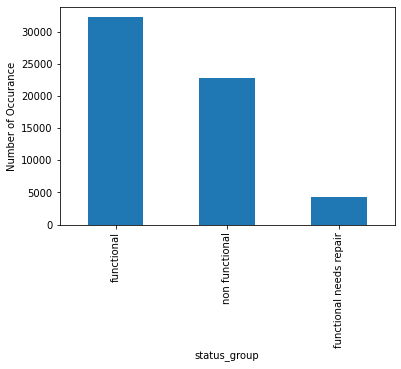

In [303]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

In [304]:
data.status_group.value_counts()


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [305]:
data.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [306]:
label_encouder=LabelEncoder()
data.status_group = label_encouder.fit_transform(data.status_group)
data.status_group.head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

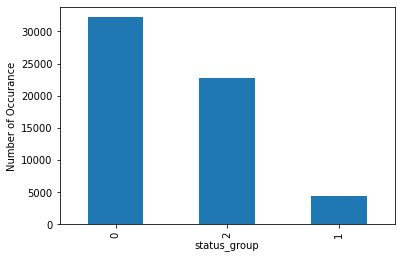

In [307]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

#3. Defining the Encoders for Use in Cross Validation

##3.1. Rare Value Encoders

In [308]:
data.select_dtypes(include='object').columns

Index(['funder', 'basin', 'region', 'lga', 'ward', 'scheme_management',
       'extraction_type', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')

In [309]:
rare_encoder = RareLabelEncoder(
  tol=0.025,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  variables=['scheme_management', 'extraction_type', 'management', 'water_quality', 'source','waterpoint_type'], # variables to re-group
  replace_with='Rare')

rare_encoder_EXtreme_Cardinality = RareLabelEncoder(
  tol=0.007,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  max_n_categories = 50,
  variables=['lga', 'funder'], # variables to re-group
  replace_with='Rare')

rare_encoder_ExCard_ward = RareLabelEncoder(
  tol=0.002,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  max_n_categories = 500,
  variables=['ward'], # variables to re-group
  replace_with='Rare')


##3.2. Categorical Encoders
https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark

https://contrib.scikit-learn.org/category_encoders/

https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53



###3.2.1. Target Encoder

In [310]:
tar_train=data.copy()
tar_test=test.copy()

In [311]:
tar_train.drop(['id'],axis=1, inplace=True)
tar_test.drop(['id'],axis=1, inplace=True)

In [312]:
status_labels =['func', 'non-func' , 'func_repair']

In [313]:
enc=OneHotEncoder().fit(tar_train.status_group.astype(str))
status_group_labels=enc.transform(tar_train.status_group.astype(str))
status_group_labels.columns = status_labels
status_group_labels.head()

,func,non-func,func_repair
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0


In [314]:
class_names=status_group_labels.columns[0:3]
class_names

Index(['func', 'non-func', 'func_repair'], dtype='object')

In [315]:
len(status_group_labels)

59400

In [316]:
variables=tar_train.select_dtypes(include='object').columns
variables

Index(['funder', 'basin', 'region', 'lga', 'ward', 'scheme_management',
       'extraction_type', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')

In [317]:
target_enc=TargetEncoder(verbose=0, cols=None, drop_invariant=True, return_df=True,
# handle_missing='value',
# handle_unknown='value',
min_samples_leaf=3,
smoothing=2,
)

###3.2.2. James_Stein Encoder
https://kiwidamien.github.io/james-stein-encoder.html

In [318]:
js_train=data.copy()
js_test=test.copy()

In [319]:
js_train.drop(['id'],axis=1, inplace=True)
js_test.drop(['id'],axis=1, inplace=True)

In [320]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', model='independent', random_state=None, randomized=False, sigma=0.05)
js_enc = JamesSteinEncoder(
    drop_invariant=True,
    model='independent', random_state=7,
    sigma=0.05
)

###3.2.3. CatBoost Encoder
https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/

In [321]:
cb_train=data.copy()
cb_test=test.copy()

In [322]:
cb_train.drop(['id'],axis=1, inplace=True)
cb_test.drop(['id'],axis=1, inplace=True)

In [323]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=None, sigma=None, a=1)
cb_enc = CatBoostEncoder(
    cols=None, drop_invariant=True,
    random_state=7,
    
)

###3.2.4. mean target Encoder


In [324]:
mtar_train=data.copy()
mtar_test=test.copy()

In [325]:
mtar_train.drop(['id'],axis=1, inplace=True)
mtar_test.drop(['id'],axis=1, inplace=True)

In [326]:
mtar_enc=TargetEncoder(verbose=0, cols=None,drop_invariant=True, return_df=True,
# handle_missing='value',
# handle_unknown='value',
min_samples_leaf=8,
smoothing=10,
)

###3.2.5. Leave One Out Encoder


In [327]:
loo_train=data.copy()
loo_test=test.copy()

In [328]:
loo_train.drop(['id'],axis=1, inplace=True)
loo_test.drop(['id'],axis=1, inplace=True)

In [329]:
loo_enc=LeaveOneOutEncoder(verbose=0, cols=None,drop_invariant=True, return_df=True,
# handle_missing='value',
# handle_unknown='value',
random_state=7
)

###3.2.6. MEstimator Encoder


In [330]:
me_train=data.copy()
me_test=test.copy()

In [331]:
me_train.drop(['id'],axis=1, inplace=True)
me_test.drop(['id'],axis=1, inplace=True)

In [332]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=None, randomized=False, sigma=0.05, m=1.0)
me_enc=MEstimateEncoder(verbose=0, cols=None,drop_invariant=True, return_df=True,
sigma=0.05, m=1.0,
random_state=7
)

#4. Defining the ML Models

In [333]:
rf_clf = RandomForestClassifier(
                            n_estimators = 1000,
                            criterion = 'entropy', 
                            max_depth = None, # 
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features= 'sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 0,
                            n_jobs = -1,
                            random_state = 17,
)

In [334]:
# importing the lightgbm module
import lightgbm as lgb
# initializing the model
LightGBM_Clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves = 50,
    max_depth=-1,
    learning_rate = 0.2,
    n_estimators=1000,
    subsample_for_bin=200000,
    objective=None,
    class_weight= None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=17, 
    n_jobs=-1, 
    silent=True, 
    importance_type='split',
    verbosity = 1,
    
)

In [335]:
xgboost_clf = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.09, # range [0,1], typically=0.01-0.2
                            n_estimators = 533,
                            verbosity = 1,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.75,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
)

In [336]:
dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=9, random_state=17)

AdaBoost_clf = AdaBoostClassifier(base_estimator=dtree,
                                  n_estimators= 543,
                                  learning_rate=0.9,
                                  algorithm='SAMME.R',
                                  random_state=7)

#5.1 Feature Engineering and Modeling within Cross Validation - Target Encoding

In [337]:
# Use the results of any categorical encoding that you chose

train = tar_train.copy()
test = tar_test.copy()

In [338]:
train.status_group

0        0
1        0
2        0
3        2
4        0
        ..
59395    0
59396    0
59397    0
59398    0
59399    0
Name: status_group, Length: 59400, dtype: int64

In [339]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [340]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8047138047138047, 1)
LightGBM_accuracy: (0.8032828282828283, 1)
xgboost_accuracy: (0.8111952861952862, 1)
>>>rf_Accuracy: (0.8026936026936027, 2)
LightGBM_accuracy: (0.797979797979798, 2)
xgboost_accuracy: (0.8088383838383838, 2)
>>>rf_Accuracy: (0.8063131313131313, 3)
LightGBM_accuracy: (0.8031986531986532, 3)
xgboost_accuracy: (0.8108585858585858, 3)
>>>rf_Accuracy: (0.8036195286195286, 4)
LightGBM_accuracy: (0.8014309764309764, 4)
xgboost_accuracy: (0.80993265993266, 4)
>>>rf_Accuracy: (0.8056397306397306, 5)
LightGBM_accuracy: (0.805976430976431, 5)
xgboost_accuracy: (0.8105218855218855, 5)
Random Forest accuracy is 0.8045959595959596
Light GBM accuracy is 0.8023737373737374
XGBoost accuracy is 0.8102693602693603
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.54      0.38      0.44       864
           2       0.84      0.78      0.81      4565

    accuracy                        

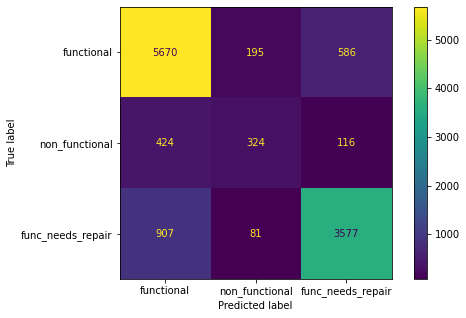

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.53      0.36      0.43       864
           2       0.84      0.79      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.72      0.68      0.69     11880
weighted avg       0.80      0.81      0.80     11880



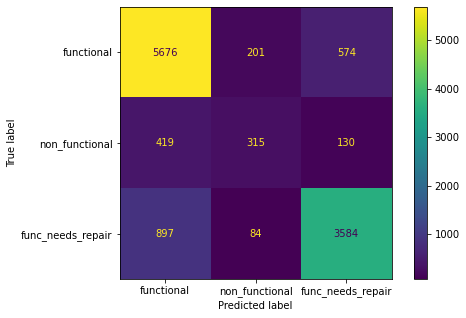

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6451
           1       0.58      0.35      0.44       864
           2       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.74      0.68      0.70     11880
weighted avg       0.81      0.81      0.80     11880



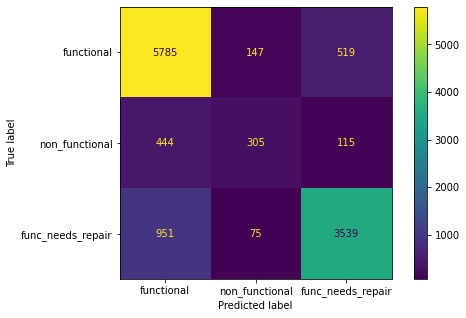

In [341]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    rare_enc_X_train = rare_encoder.transform(X_train)
    rare_enc_X_train = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_train)
    rare_enc_X_train = rare_encoder_ExCard_ward.transform(rare_enc_X_train)

    rare_enc_X_test = rare_encoder.transform(X_test)
    rare_enc_X_test = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_test)
    rare_enc_X_test = rare_encoder_ExCard_ward.transform(rare_enc_X_test)

    #Fitting the Categorical encoders
    for var in variables:
      for class_ in class_names:
        # print(enc.fit_transform(data,status_group_labels[class_]))
        target_enc = target_enc.fit(X_train[var],status_group_labels.loc[train_index][class_])
        X_train[var + '_' + class_] = target_enc.transform(X_train[var])
        X_test[var + '_' + class_] = target_enc.transform(X_test[var])
        
    X_train = X_train.drop(variables,axis=1)
    X_test = X_test.drop(variables,axis=1)  


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_AdaBoost = AdaBoost_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_AdaBoost)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')




    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.2 Feature Engineering and Modeling within Cross Validation - CatBoost Encoding

In [342]:
# Use the results of any categorical encoding that you chose

train = cb_train.copy()
test = cb_test.copy()

In [343]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [344]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8088383838383838, 1)
LightGBM_accuracy: (0.8062289562289562, 1)
xgboost_accuracy: (0.8128787878787879, 1)
>>>rf_Accuracy: (0.805976430976431, 2)
LightGBM_accuracy: (0.8026936026936027, 2)
xgboost_accuracy: (0.8077441077441078, 2)
>>>rf_Accuracy: (0.8081649831649832, 3)
LightGBM_accuracy: (0.8053872053872054, 3)
xgboost_accuracy: (0.8105218855218855, 3)
>>>rf_Accuracy: (0.8076599326599326, 4)
LightGBM_accuracy: (0.8064814814814815, 4)
xgboost_accuracy: (0.8111111111111111, 4)
>>>rf_Accuracy: (0.8080808080808081, 5)
LightGBM_accuracy: (0.8035353535353535, 5)
xgboost_accuracy: (0.8121212121212121, 5)
Random Forest accuracy is 0.8077441077441078
Light GBM accuracy is 0.8048653198653198
XGBoost accuracy is 0.810875420875421
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.57      0.36      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                      

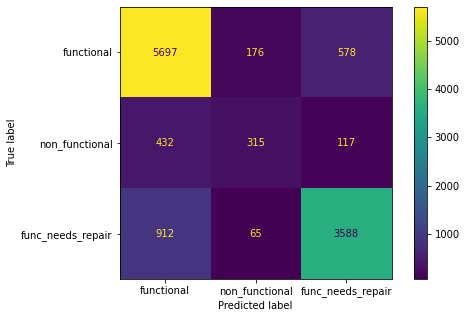

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.52      0.35      0.42       864
           2       0.83      0.78      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880



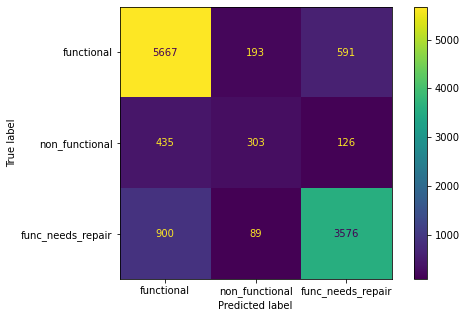

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6451
           1       0.63      0.33      0.43       864
           2       0.84      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.70     11880
weighted avg       0.81      0.81      0.80     11880



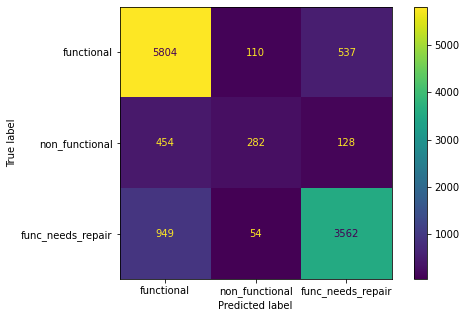

In [345]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    rare_enc_X_train = rare_encoder.transform(X_train)
    rare_enc_X_train = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_train)
    rare_enc_X_train = rare_encoder_ExCard_ward.transform(rare_enc_X_train)

    rare_enc_X_test = rare_encoder.transform(X_test)
    rare_enc_X_test = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_test)
    rare_enc_X_test = rare_encoder_ExCard_ward.transform(rare_enc_X_test)

    #Fitting the Categorical encoders
    cat_ecn = cb_enc.fit(X_train, y_train)
    X_train = cb_enc.transform(X_train)
    X_test = cb_enc.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.3 Feature Engineering and Modeling within Cross Validation - Mean Target Encoding

In [346]:
# Use the results of any categorical encoding that you chose

train = mtar_train.copy()
test = mtar_test.copy()

In [347]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [348]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8087542087542088, 1)
LightGBM_accuracy: (0.8085016835016835, 1)
xgboost_accuracy: (0.8122053872053872, 1)
>>>rf_Accuracy: (0.8058922558922559, 2)
LightGBM_accuracy: (0.8044612794612794, 2)
xgboost_accuracy: (0.80993265993266, 2)
>>>rf_Accuracy: (0.8089225589225589, 3)
LightGBM_accuracy: (0.8058922558922559, 3)
xgboost_accuracy: (0.812962962962963, 3)
>>>rf_Accuracy: (0.8062289562289562, 4)
LightGBM_accuracy: (0.8036195286195286, 4)
xgboost_accuracy: (0.8112794612794613, 4)
>>>rf_Accuracy: (0.8098484848484848, 5)
LightGBM_accuracy: (0.8044612794612794, 5)
xgboost_accuracy: (0.8142255892255892, 5)
Random Forest accuracy is 0.8079292929292929
Light GBM accuracy is 0.8053872053872053
XGBoost accuracy is 0.8121212121212121
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6451
           1       0.57      0.36      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                       

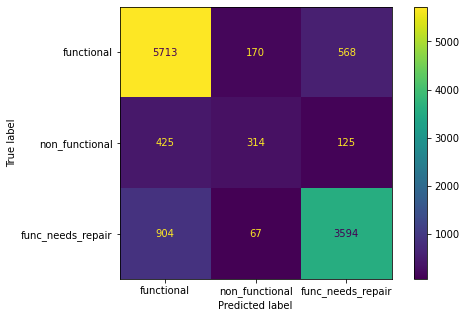

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.53      0.34      0.42       864
           2       0.83      0.79      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880



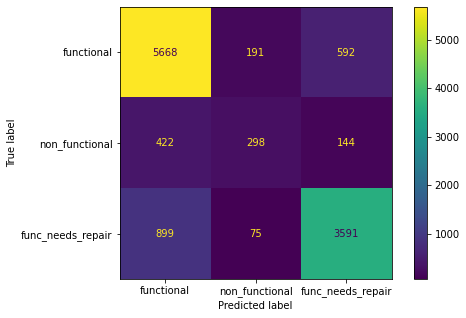

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6451
           1       0.62      0.33      0.43       864
           2       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.70     11880
weighted avg       0.81      0.81      0.81     11880



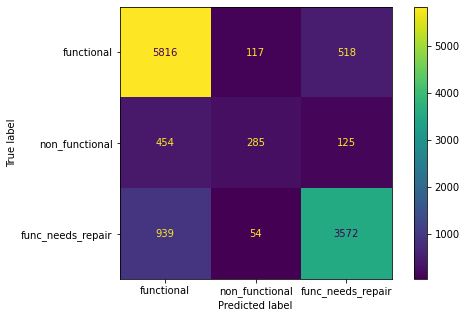

In [349]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    rare_enc_X_train = rare_encoder.transform(X_train)
    rare_enc_X_train = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_train)
    rare_enc_X_train = rare_encoder_ExCard_ward.transform(rare_enc_X_train)

    rare_enc_X_test = rare_encoder.transform(X_test)
    rare_enc_X_test = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_test)
    rare_enc_X_test = rare_encoder_ExCard_ward.transform(rare_enc_X_test)

    #Fitting the Categorical encoders
    mtar_ecn = mtar_enc.fit(X_train, y_train)
    X_train = mtar_enc.transform(X_train)
    X_test = mtar_enc.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.4 Feature Engineering and Modeling within Cross Validation - LeaveOneOut Encoding

In [350]:
# Use the results of any categorical encoding that you chose

train = loo_train.copy()
test = loo_test.copy()

In [351]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [352]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8094276094276094, 1)
LightGBM_accuracy: (0.8077441077441078, 1)
xgboost_accuracy: (0.8095117845117845, 1)
>>>rf_Accuracy: (0.8063973063973064, 2)
LightGBM_accuracy: (0.8013468013468014, 2)
xgboost_accuracy: (0.8063973063973064, 2)
>>>rf_Accuracy: (0.8081649831649832, 3)
LightGBM_accuracy: (0.803956228956229, 3)
xgboost_accuracy: (0.8136363636363636, 3)
>>>rf_Accuracy: (0.8076599326599326, 4)
LightGBM_accuracy: (0.8015151515151515, 4)
xgboost_accuracy: (0.8103535353535354, 4)
>>>rf_Accuracy: (0.807070707070707, 5)
LightGBM_accuracy: (0.80496632996633, 5)
xgboost_accuracy: (0.8116161616161616, 5)
Random Forest accuracy is 0.8077441077441078
Light GBM accuracy is 0.8039057239057239
XGBoost accuracy is 0.8103030303030303
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.56      0.36      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                        

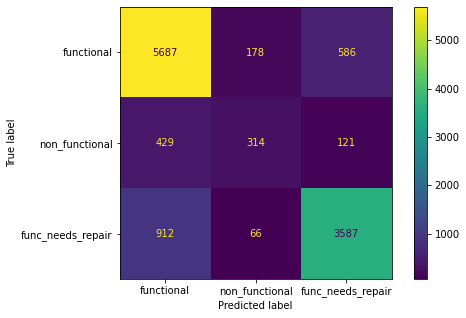

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.52      0.35      0.42       864
           2       0.83      0.79      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880



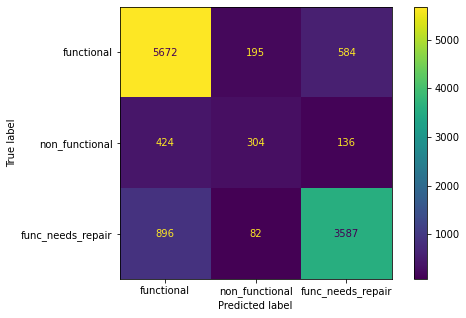

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6451
           1       0.65      0.33      0.44       864
           2       0.84      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.70     11880
weighted avg       0.81      0.81      0.80     11880



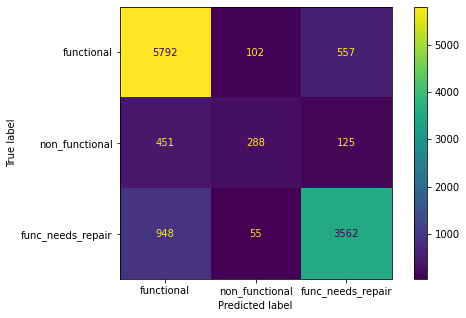

In [353]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    rare_enc_X_train = rare_encoder.transform(X_train)
    rare_enc_X_train = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_train)
    rare_enc_X_train = rare_encoder_ExCard_ward.transform(rare_enc_X_train)

    rare_enc_X_test = rare_encoder.transform(X_test)
    rare_enc_X_test = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_test)
    rare_enc_X_test = rare_encoder_ExCard_ward.transform(rare_enc_X_test)

    #Fitting the Categorical encoders
    loo_ecn = loo_enc.fit(X_train, y_train)
    X_train = loo_enc.transform(X_train)
    X_test = loo_enc.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)



print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5.5 Feature Engineering and Modeling within Cross Validation - MEstimate Encoding

In [354]:
# Use the results of any categorical encoding that you chose

train = loo_train.copy()
test = loo_test.copy()

In [355]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [356]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8077441077441078, 1)
LightGBM_accuracy: (0.8047979797979798, 1)
xgboost_accuracy: (0.8118686868686869, 1)
>>>rf_Accuracy: (0.8064814814814815, 2)
LightGBM_accuracy: (0.802946127946128, 2)
xgboost_accuracy: (0.8074915824915825, 2)
>>>rf_Accuracy: (0.8077441077441078, 3)
LightGBM_accuracy: (0.8021043771043771, 3)
xgboost_accuracy: (0.8096801346801347, 3)
>>>rf_Accuracy: (0.8047979797979798, 4)
LightGBM_accuracy: (0.8014309764309764, 4)
xgboost_accuracy: (0.8066498316498316, 4)
>>>rf_Accuracy: (0.8087542087542088, 5)
LightGBM_accuracy: (0.8021043771043771, 5)
xgboost_accuracy: (0.8116161616161616, 5)
Random Forest accuracy is 0.8071043771043771
Light GBM accuracy is 0.8026767676767677
XGBoost accuracy is 0.8094612794612793
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.57      0.36      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                     

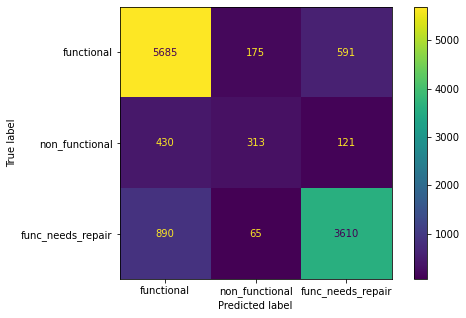

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.53      0.35      0.42       864
           2       0.83      0.78      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880



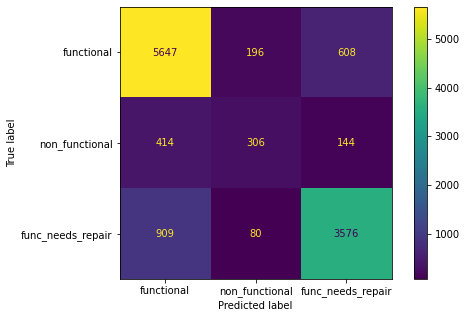

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6451
           1       0.64      0.33      0.43       864
           2       0.84      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.70     11880
weighted avg       0.81      0.81      0.80     11880



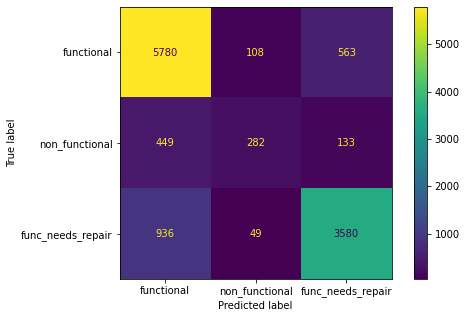

In [357]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    rare_enc_X_train = rare_encoder.transform(X_train)
    rare_enc_X_train = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_train)
    rare_enc_X_train = rare_encoder_ExCard_ward.transform(rare_enc_X_train)

    rare_enc_X_test = rare_encoder.transform(X_test)
    rare_enc_X_test = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_test)
    rare_enc_X_test = rare_encoder_ExCard_ward.transform(rare_enc_X_test)

    #Fitting the Categorical encoders
    me_ecn = me_enc.fit(X_train, y_train)
    X_train = me_enc.transform(X_train)
    X_test = me_enc.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

#5. Feature Engineering and Modeling within Cross Validation - James-Stein Encoding

In [358]:
# Use the results of any categorical encoding that you chose

train = js_train.copy()
test = js_test.copy()

In [359]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [360]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8084175084175084, 1)
LightGBM_accuracy: (0.8027777777777778, 1)
xgboost_accuracy: (0.8095959595959596, 1)
>>>rf_Accuracy: (0.8053872053872054, 2)
LightGBM_accuracy: (0.7994949494949495, 2)
xgboost_accuracy: (0.8048821548821549, 2)
>>>rf_Accuracy: (0.8079124579124579, 3)
LightGBM_accuracy: (0.8031144781144781, 3)
xgboost_accuracy: (0.8101010101010101, 3)
>>>rf_Accuracy: (0.8051346801346801, 4)
LightGBM_accuracy: (0.8010942760942761, 4)
xgboost_accuracy: (0.8084175084175084, 4)
>>>rf_Accuracy: (0.8076599326599326, 5)
LightGBM_accuracy: (0.8018518518518518, 5)
xgboost_accuracy: (0.8083333333333333, 5)
Random Forest accuracy is 0.8069023569023569
Light GBM accuracy is 0.8016666666666665
XGBoost accuracy is 0.8082659932659932
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.56      0.37      0.44       864
           2       0.83      0.79      0.81      4565

    accuracy                    

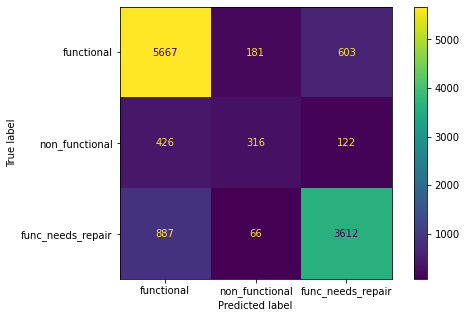

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6451
           1       0.53      0.36      0.43       864
           2       0.83      0.79      0.81      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880



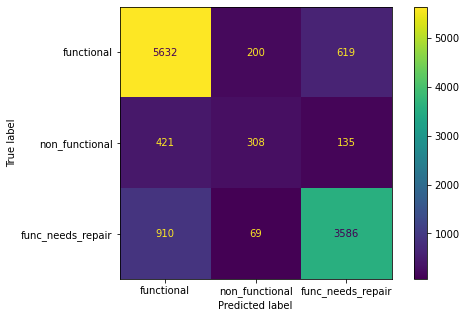

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      6451
           1       0.63      0.32      0.43       864
           2       0.84      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880



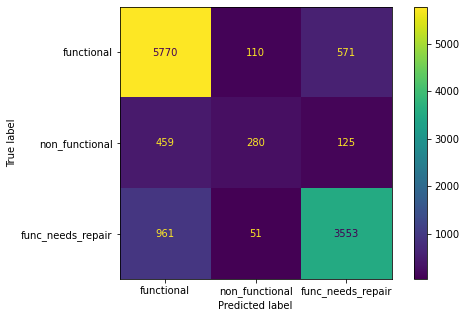

In [361]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    rare_enc_X_train = rare_encoder.transform(X_train)
    rare_enc_X_train = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_train)
    rare_enc_X_train = rare_encoder_ExCard_ward.transform(rare_enc_X_train)

    rare_enc_X_test = rare_encoder.transform(X_test)
    rare_enc_X_test = rare_encoder_EXtreme_Cardinality.transform(rare_enc_X_test)
    rare_enc_X_test = rare_encoder_ExCard_ward.transform(rare_enc_X_test)

    #Fitting the Categorical encoders
    me_ecn = js_enc.fit(X_train, y_train)
    X_train = js_enc.transform(X_train)
    X_test = js_enc.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#adaboost
    # AdaBoost_clf.fit(X_train, y_train)
    # y_pred_rf = rf_clf.predict(X_test)
    # AdaBoostt_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    # mean_acc_ada += AdaBoostt_accuracy
    # print(f'AdaBoostt_accuracy: {AdaBoostt_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)



print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();